In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack, csr_matrix
from classifier import *
from utils import load_cleaned_data, metrics, plot_confusion_matrix, store_metrics

In [ ]:
results = []
# === Load Data ===
train_df = load_cleaned_data("byarticle_clean.tsv")
test_df = load_cleaned_data("byarticle_clean_test.tsv")

# === Define Labels ===
X_train_text = train_df['full_text']
X_test_text = test_df['full_text']
y_train = train_df['label']
y_test = test_df['label']

In [ ]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']  # Ranges from -1 to 1

train_df['sentiment_score'] = train_df['full_text'].apply(vader_sentiment)
test_df['sentiment_score'] = test_df['full_text'].apply(vader_sentiment)


In [ ]:
#Additional features
!pip install textstat
import textstat

trigger_words = {"liberal", "conservative", "patriot", "radical", "traitor", "hoax", "freedom"}

def enrich_features(df):
    df['abs_sentiment'] = df['sentiment_score'].abs() #strong emotion either way
    df['subjectivity'] = df['full_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['trigger_count'] = df['full_text'].apply(lambda x: sum(w in trigger_words for w in x.lower().split()))
    df['flesch'] = df['full_text'].apply(lambda x: textstat.flesch_reading_ease(x))
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))

    df['polarity'] = df['full_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['lexical_diversity'] = df['full_text'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
    df['question_marks'] = df['full_text'].str.count(r'\?')


    return df

train_df = enrich_features(train_df)
test_df = enrich_features(test_df)


In [ ]:
style_features = [
    'word_count',
    'uppercase_ratio',
    'subjectivity',
    'avg_sentence_length',
    'polarity',
    'lexical_diversity',
    'question_marks'
]

In [ ]:
# === TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english", ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# === Scale Style Features ===
scaler = MinMaxScaler()
X_train_style = csr_matrix(scaler.fit_transform(train_df[style_features]))
X_test_style = csr_matrix(scaler.transform(test_df[style_features]))

# === Combine TF-IDF + Style ===
X_train_comb = hstack([X_train_vec, X_train_style])
X_test_comb = hstack([X_test_vec, X_test_style])

# === Convert to dense for Random Forest ===
X_train_comb = X_train_comb.toarray()
X_test_comb = X_test_comb.toarray()

# === Apply Random Oversampling ===
ros = RandomOverSampler(random_state=0)
X_train_final, y_train_final = ros.fit_resample(X_train_comb, y_train)

                  Feature  Importance
2000           word_count    0.011790
1843                trump    0.007607
2005    lexical_diversity    0.005898
2002         subjectivity    0.005639
2004             polarity    0.005365
951                  just    0.004825
2001      uppercase_ratio    0.004731
2006       question_marks    0.004489
2003  avg_sentence_length    0.004444
819               hillary    0.004414
1338            political    0.004391
1366            president    0.004300
1371      president trump    0.004223
1990                years    0.004037
546                 doesn    0.003740
1341             politics    0.003626
820       hillary clinton    0.003509
662                   far    0.003443
1532                right    0.003405
1073                 make    0.003278
Accuracy: 0.75
Balanced Accuracy: 0.75
Precision: 0.84
Recall: 0.62
F1: 0.71
AUC: 0.85


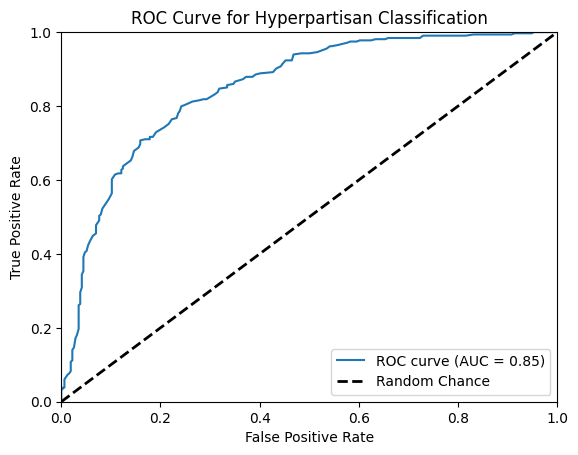

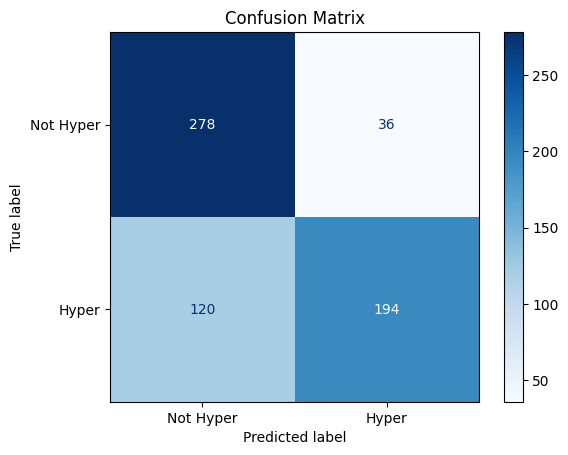

In [ ]:
# === Initialize Random Forest with Best Parameters ===
best_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    max_features='log2',
    random_state=0
)

# === Train the Model ===
best_rf.fit(X_train_final, y_train_final)

# === Find top features
importances = best_rf.feature_importances_

# Get TF-IDF feature names
tfidf_features = vectorizer.get_feature_names_out().tolist()

# Combine with style feature names
all_feature_names = tfidf_features + style_features  # Order matters!

# Sanity check:
assert len(all_feature_names) == len(importances)

import pandas as pd

importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort descending
top_features = importance_df.sort_values(by='Importance', ascending=False)

# Show top 20
print(top_features.head(20))




# === Predict and Evaluate ===
y_pred = best_rf.predict(X_test_comb)
y_pred_proba = best_rf.predict_proba(X_test_comb)[:, 1]

# Evaluate using utils
metrics(y_test, y_pred, y_pred_proba)
plot_confusion_matrix(y_test, y_pred)
store_metrics(results, "Random Forest", f"TF-IDF(2000) + Style + ROS new features", y_test, y_pred, y_pred_proba)

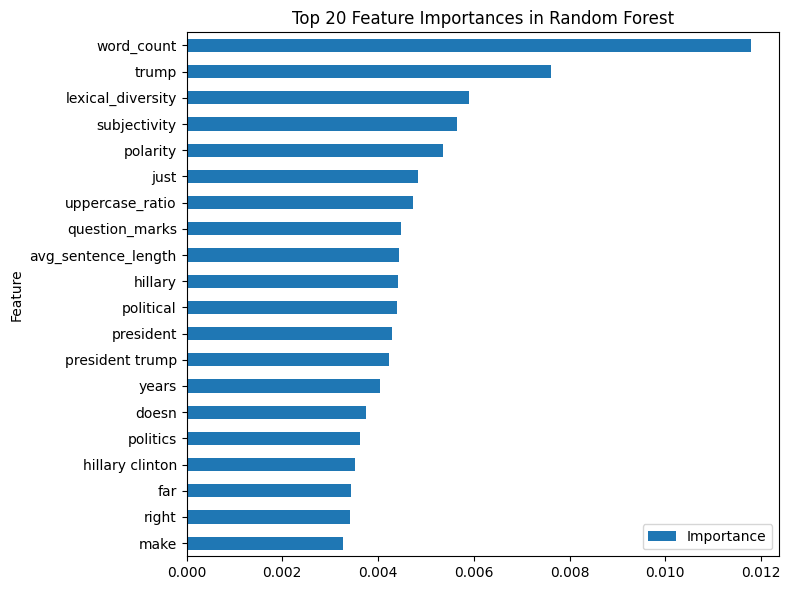

In [ ]:
import matplotlib.pyplot as plt

top_features.head(20).plot(kind='barh', x='Feature', y='Importance', figsize=(8, 6))
plt.title("Top 20 Feature Importances in Random Forest")
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


# Save model

In [ ]:
from classifier import save_full_model

# Define metadata (optional but useful)
metadata = {
    "features": {
        "vectorizer": "TF-IDF (1,2)-gram, max_features=2000, stopwords=english",
        "style": style_features
    },
    "oversampling": "RandomOverSampler",
    "model_params": best_rf.get_params()
}

# Save everything
save_full_model(
    model=best_rf,
    vectorizer=vectorizer,
    scaler=scaler,
    metadata=metadata,
    output_dir="models",
    name="best_rf_model"
)


 Model, vectorizer, scaler, and metadata saved to models/
